author: leezeeyee   
date: 2021/4/15    
link: [github](https://github.com/easilylazy/pattern-recognition) 

In [1]:
import numpy as np
import torch

In [2]:
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

## 字母识别
2，用3*3的矩阵共9维特征来表示字母，假设   
向量(0，1，0，0，1，0，0，1，0)T表示字母“I”，    
向量(1，1，1，0，1，0，0，1，0)T表示字母“T”，    
向量(1，0，1，1，0，1，1，1，1)T表示字母“U”，   
请自行设计神经网络实现对这三个字母的识别，希望能通过设计不同的隐含层数、每层的节点数、不同的学习率、不同的激活函数等对实验结果进行讨论。

## 过程中的问题与思考

1. 学习率很低，不收敛    
不知是否是算法有问题，更换数据后有所改善
因此需要调整网络结构
2. 增加网络隐藏层的节点数，收敛速度增加
3. 增加学习率，SGD的收敛速度有所提升

其实对于这部分的训练可视为过拟合的过程，没有测试集的验证

### 数据

In [6]:
string='1，0，1，1，0，1，1，1，1'
string.replace('，',',')

'1,0,1,1,0,1,1,1,1'

In [7]:
D=np.asarray([[0,1,0,0,1,0,0,1,0],[1,1,1,0,1,0,0,1,0],[1,0,1,1,0,1,1,1,1]])
Y=np.array([0,1,2],dtype=np.int64)

In [8]:
D = D.astype(np.float32)
D_np = torch.from_numpy(D)
# D_np
Y_np=torch.tensor(Y)
# Y_np

In [9]:
train_data=[]
for i in range(len(D)):
    train_data.append([D_np[i],Y_np[i]])

In [10]:
batch_size = 1

# Create data loaders.
train_dataloader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X in train_dataloader:
    # print("Shape of X [N, C, H, W]: ", X.shape)
    print(X)
    # print("Shape of y: ", y.shape, y.dtype)
    break

[tensor([[1., 1., 1., 0., 1., 0., 0., 1., 0.]]), tensor([1])]


In [11]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([1, 9])
Labels batch shape: torch.Size([1])


In [12]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.ReLU(),
            nn.Linear(9, 18),
            nn.ReLU(),
            # nn.Linear(8, 3),
            nn.Linear(18, 5),
            nn.ReLU(),
            nn.Linear(5, 3),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits



Using cpu device


In [13]:
for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        print(X)
        print(y)

tensor([[1., 0., 1., 1., 0., 1., 1., 1., 1.]])
tensor([2])
tensor([[1., 1., 1., 0., 1., 0., 0., 1., 0.]])
tensor([1])
tensor([[0., 1., 0., 0., 1., 0., 0., 1., 0.]])
tensor([0])


In [14]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        # y=torch.tensor(y,dtype=torch.long)
        # print(pred,y)
        # print('sf')
        # print(pred[0][y[0]])
        loss = loss_fn(pred, y)
        # loss=(pred-y)**2
        # print(pred.argmax(1)==y)

        # print(loss)
        # print(loss.grad_fn)
        # Backpropagation
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        # if batch % 8 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [15]:
def test(dataloader, model, epoch):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # print(pred)
            # print(pred.argmax(1))
            # print(y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    # if epoch%10==0:
    #     print(f"Epoch {t+1}\n-------------------------------")
    #     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss,correct

In [18]:
model = NeuralNetwork().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

NeuralNetwork(
  (flatten): Flatten()
  (linear_relu_stack): Sequential(
    (0): ReLU()
    (1): Linear(in_features=9, out_features=18, bias=True)
    (2): ReLU()
    (3): Linear(in_features=18, out_features=5, bias=True)
    (4): ReLU()
    (5): Linear(in_features=5, out_features=3, bias=True)
  )
)


In [21]:
epochs = 1000
# fig=plt.figure()
maxCorrect=0
for t in range(epochs):
    
    train(train_dataloader, model, loss_fn, optimizer)
    loss,correct=test(train_dataloader, model,t)
    if correct>maxCorrect:
        print(loss)
        print(correct)
        maxCorrect=correct
        if abs(maxCorrect-1)<1e-6:
            break
    # plt.plot(t,loss,'o')
print("Done!")

0.6395428776741028
1.0
Done!


1.1478555003801982
0.3333333333333333
1.071012059847514
0.6666666666666666
0.642576664686203
1.0


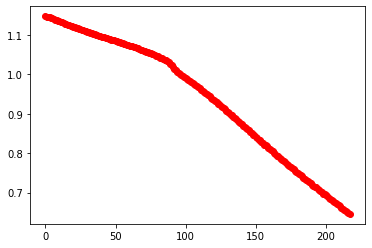

In [20]:
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
epochs = 1000
fig=plt.figure()
maxCorrect=0
for t in range(epochs):
    
    train(train_dataloader, model, loss_fn, optimizer)
    loss,correct=test(train_dataloader, model,t)
    if correct>maxCorrect:
        print(loss)
        print(correct)
        maxCorrect=correct
        if abs(maxCorrect-1)<1e-6:
            break
    plt.plot(t,loss,'o',color='r')